## Stock prediction using a RNN with GNU and LSTM cells

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf

### 1) Get S&P 500 data from the yfinance library
Get the historical data from 2000 to today and transform it to a range from 0 to 1

In [35]:
sp500 = yf.Ticker('^GSPC')
historical_data = sp500.history(start='2000-01-01', end='2024-06-09')
dataset = historical_data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

### 2) Train the model

In [46]:
look_back = 20
epochs = 10
batch_size = 1
verbose = 2

In [47]:
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [53]:
X, Y = create_dataset(dataset_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [49]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
fitted = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/10
4900/4900 - 35s - loss: 1.6453e-04 - 35s/epoch - 7ms/step
Epoch 2/10
4900/4900 - 32s - loss: 5.9687e-05 - 32s/epoch - 7ms/step
Epoch 3/10
4900/4900 - 33s - loss: 4.2457e-05 - 33s/epoch - 7ms/step
Epoch 4/10
4900/4900 - 33s - loss: 4.0928e-05 - 33s/epoch - 7ms/step
Epoch 5/10
4900/4900 - 33s - loss: 3.6138e-05 - 33s/epoch - 7ms/step
Epoch 6/10
4900/4900 - 33s - loss: 3.1604e-05 - 33s/epoch - 7ms/step
Epoch 7/10
4900/4900 - 33s - loss: 3.0252e-05 - 33s/epoch - 7ms/step
Epoch 8/10
4900/4900 - 33s - loss: 2.9394e-05 - 33s/epoch - 7ms/step
Epoch 9/10
4900/4900 - 32s - loss: 2.7084e-05 - 32s/epoch - 7ms/step
Epoch 10/10
4900/4900 - 32s - loss: 2.9272e-05 - 32s/epoch - 7ms/step


In [50]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

39/39 [==============================] - 1s 6ms/step


In [51]:
mse = mean_squared_error(Y_test_inv, predictions)
print("MSE:", mse)
mae = mean_absolute_error(Y_test_inv, predictions)
print("MAE:", mae)
rmse = np.sqrt(mean_squared_error(Y_test_inv, predictions))
print("RMSE:", rmse)

MSE: 16673.053068436035
MAE: 102.3294004655001
RMSE: 129.12417693226948


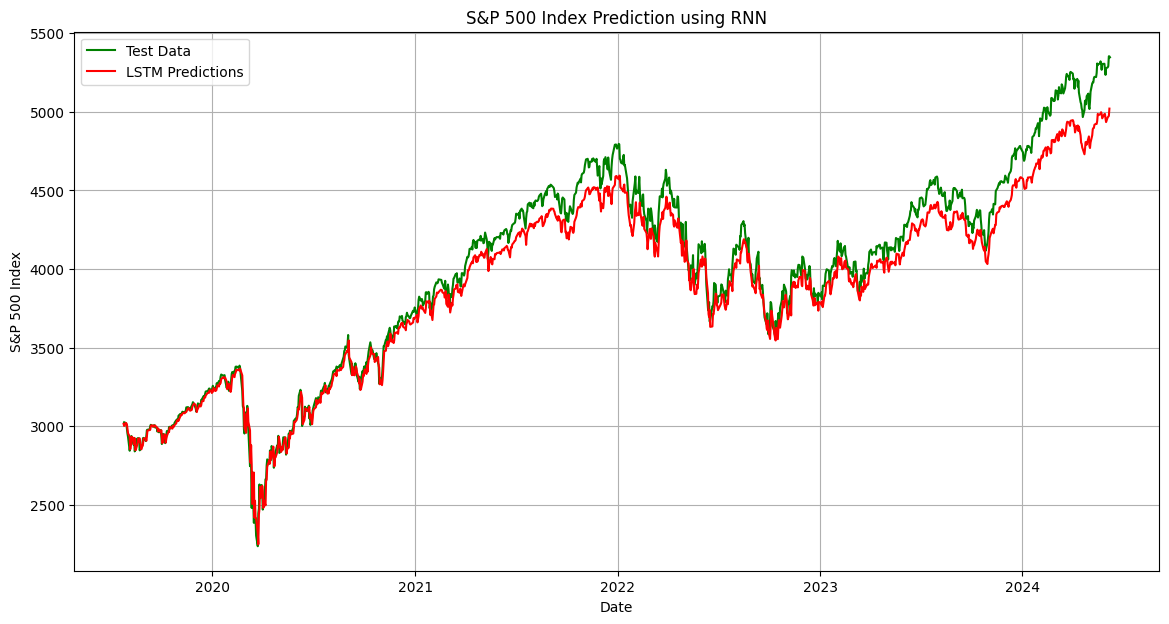

In [54]:
plot = np.empty_like(dataset)
plot[:, :] = np.nan

dates = historical_data.index[-test_size:]
last_values = dataset[-test_size:]

plot[train_size + look_back:train_size + look_back + len(predictions), :] = predictions

plt.figure(figsize=(14, 7))

plt.plot(dates, last_values, color="green", label='Test Data')

plt.plot(historical_data.index, plot, color="red", label='LSTM Predictions')

plt.xlabel('Date')
plt.ylabel('S&P 500 Index')
plt.title('S&P 500 Index Prediction using RNN')

plt.legend()
plt.grid(True)
plt.show()